Looking back four years ago to the United States's 2016 Presidential election, it can be easy to forget how confident people were that Trump couldn't possibly win the race. With the 2020 election fast approaching, it is critical that we can understand what led to his victory and how that might influence the upcoming result. We will do this not by relying on speculation or political opinion, but by showcasing a data-driven regression model that we can use to reliably intuit the primary demographic and socio-economic factors that led to Trump's victory. In doing this, we seek to answer two questions:

1. Despite his overall unpopularity, how did Trump pull off an election victory? 

2. Why did this come as such a surprise?



In [2]:
#### IMPORTS ####
# Conflict handling
library(conflicted)
conflict_prefer('arrange', 'dplyr')
conflict_prefer("filter", "dplyr")
conflict_prefer("lag", "dplyr")
conflict_prefer('mutate', 'dplyr')
conflict_prefer('rename', 'dplyr')
conflict_prefer("summarise", "dplyr")

# Data import
library(foreign)
library(jsonlite)
library(readr)

# Data manipulation
library(dplyr)
library(forcats)
library(ggplot2)
library(magrittr)
library(plyr)
library(purrr)
library(stringr)
library(tidyr)

# Modelling
library(plsdepot)

[conflicted] Will prefer dplyr::arrange over any other package

[conflicted] Will prefer dplyr::filter over any other package

[conflicted] Will prefer dplyr::lag over any other package

[conflicted] Will prefer dplyr::mutate over any other package

[conflicted] Will prefer dplyr::rename over any other package

[conflicted] Will prefer dplyr::summarise over any other package

------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

------------------------------------------------------------------------------



In [3]:
#### THEMING ####
theme_set(theme_bw(base_size = 16))

In [4]:
#### PREPARE DATA ####
# Load helpers
source('helpers/import.R')
source('helpers/clean.R')

# Import and clean
general <- import_general('data/states.json') %>%
  clean_general()
economy <- import_economy('data/economy_data.csv') %>%
  clean_economy()
education <- import_education('data/edu_data.csv') %>%
  clean_education()
religion <- import_religion('data/relig_data.csv') %>%
  clean_religion()

# Combine datasets
combi <- general %>%
  inner_join(economy, by = c('state' = 'State', 'county' = 'County')) %>%
  inner_join(education, by = c('state', 'county' = 'area_name')) %>%
  inner_join(religion, by = c('state', 'county'))

## How Trump Won (and Lost)

To address our first question, despite losing the national popular vote, Trump was returned as president in 2016 by the electoral college. That is, despite having less votes overall, the states that he did win were such that he ended up with more college votes allocated to him than Clinton did, and so claimed his victory. This is intuitive when we see that Clinton won heavily in large states, such as California (by a wide 30% margin), giving her 55 college votes, whilst Trump won by less than a percent in Michigan, Pennsylvania, and Wisconsin, as well as taking Florida by 1.2%, winning him 75 college votes for these alone. These small wins count for far more than Clinton blowing Trump away in California, since a state victory leads to the same amount of college votes regardless of the margin.



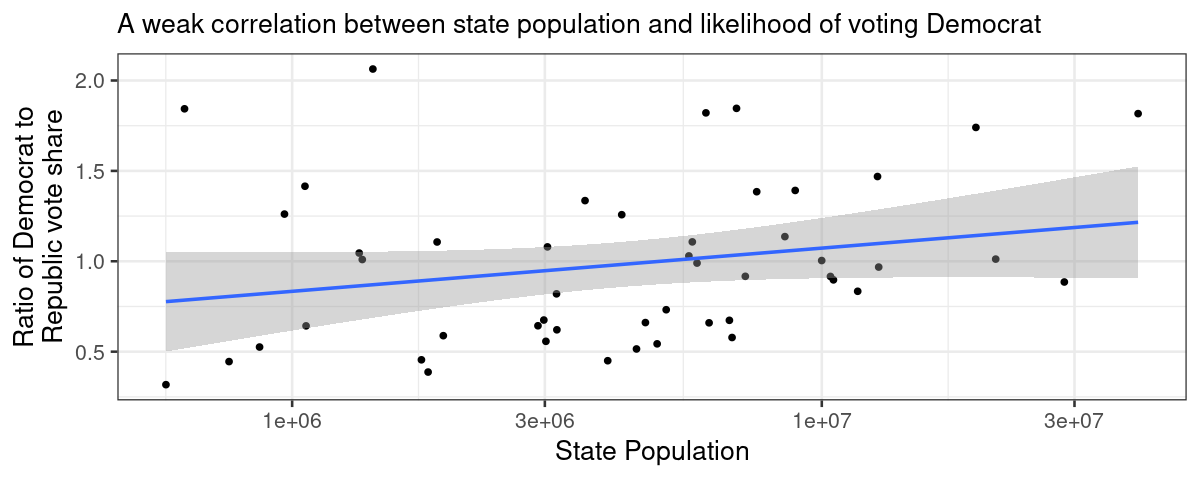

In [21]:
options(repr.plot.width = 10, repr.plot.height = 4)

combi %>%
    group_by(state) %>%
    summarise(
        tot_pop = sum(population),
        tot_dem = sum(population * dem16),
        tot_gop = sum(population * gop16),
        .groups = 'drop'
    ) %>%
    mutate(ratio = tot_dem / tot_gop) %>%
    ggplot(aes(tot_pop, ratio)) +
        geom_point() +
        geom_smooth(method = 'lm', formula = y ~ x) +
        scale_x_log10() + 
        labs(
            x = "State Population",
            y = "Ratio of Democrat to\nRepublic vote share",
            subtitle = "A weak correlation between state population and likelihood of voting Democrat"
        )

Since this system is so state-centric, we can pinpoint exactly where Trump won electoral votes that in turn won him the election. There were only six states that changed party, all switching from voting Obama to voting Trump. This can be shown on an electoral map of the US. All states which voted Republican in 2012 and 2016 are in red, whilst blue denotes the same for the Democrats. Greyed states are those which voted Obama, then Trump. Effectively, these 6 states decided the president. 



Incredibly, of these 6 states, 4 of them were won by a percent or less. In the others—Ohio and Iowa—Trump saw a huge swing his way, winning both by close to 10%. 
Aside from these margins, the other crucial thing to note is the geographical proximity of 5 of these states. Broadly, these are all part of the midwest, and make up a region known as the “rust belt”. These used to be manufacturing powerhouses of the US, are largely white, and (owing to the US’s departure from a manufacturing economy) have rising unemployment. One of the key outcomes of this project is to demonstrate that Trump’s departure from typical Republican vote shares gave him the perfect coalition of states to win the White House without needing the national popular vote. To understand exactly how these states shot him to victory, we'll need a statistical model to help us grapple with the complexities of election dynamics.

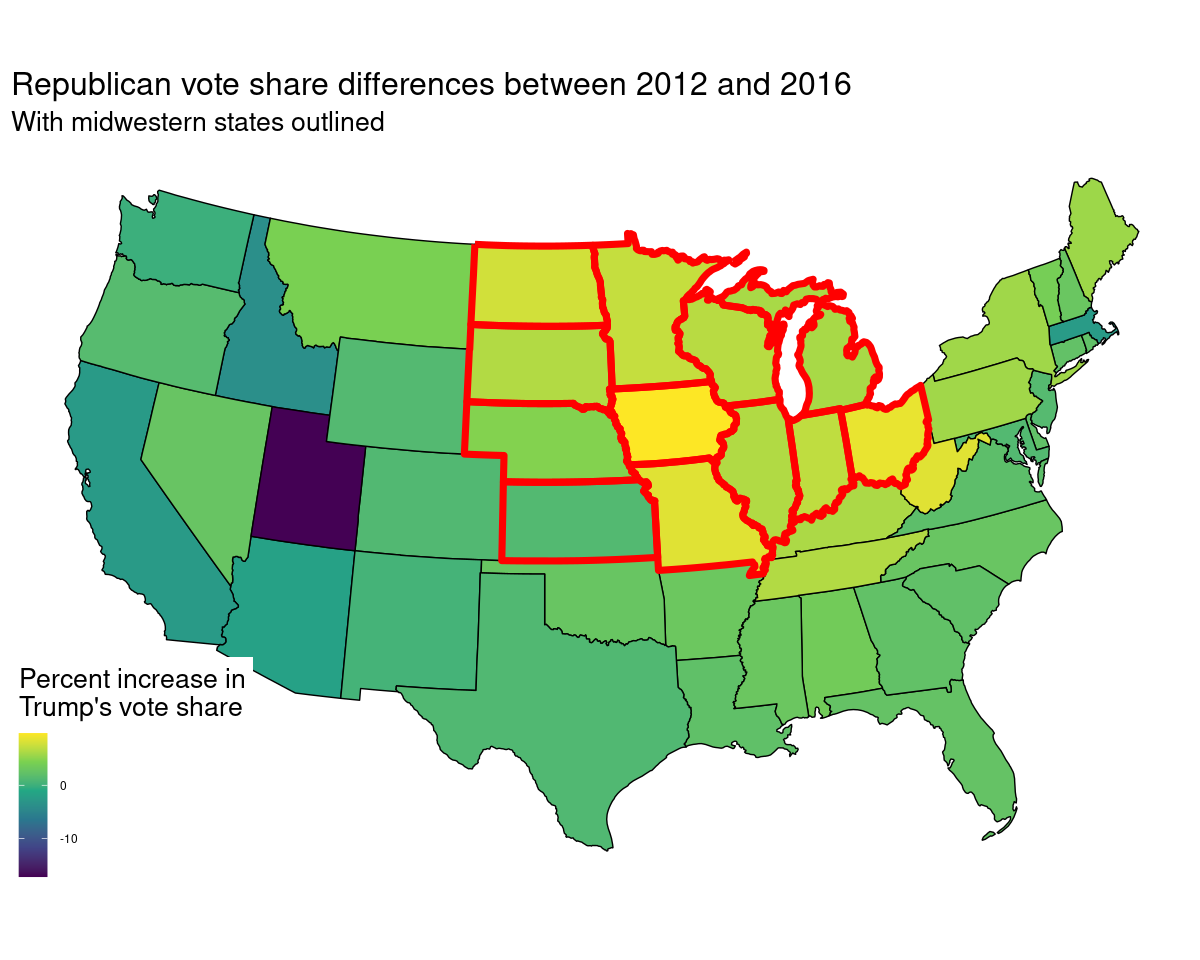

In [31]:
options(repr.plot.width = 10, repr.plot.height = 8)

oldw <- getOption("warn")
options(warn=-1)
combi %>%
  select_('state', 'diff1216') %>%
  group_by(state) %>%
  summarise(mean_diff = 100 * mean(diff1216, na.rm = TRUE), .groups = 'drop') %>%
  usmap::plot_usmap(regions = 'state', data = ., exclude = c("Alaska", "Hawaii"),
                    values = 'mean_diff') +
  geom_path(data = usmap::us_map() %>% filter(abbr %in% usmap::`.midwest_region`), aes(x, y, group = paste(abbr, piece)), col = 'red', size = 2) +
  labs(fill = "Percent increase in\nTrump's vote share",
       title = "Republican vote share differences between 2012 and 2016",
       subtitle = "With midwestern states outlined") +
  scale_fill_viridis_c() +
  theme(title = element_text(size = 16))
options(warn=oldw)

## Modelling the Problem

In order to understand what led to Trump's victory, we needed to develop a model that can capture the complex relationships between voter attributes and election outcomes. After trawling the web for relevant data sources, we ended up with enough fine-grained data to model the problem at a county level. This included demographic and socio-economic breakdowns for each county, as well as the presidential election vote counts for the years 2008, 2012, and 2016.

We took this data and formed a model in which we aimed to predict, for each county, the difference in Republican vote share from 2008/2012 to 2016 based on the descriptors we had available. By inspecting the coefficients of this model, we would then be able to intuit the impact that various demographic and socio-economic factors had on Trump's victory. 

This framework of modeling is highly complex, with a large number of correlated inputs and two correlated outputs (the 2008/16 and 20012/16 differences). A naïve approach would be to fit a multivariate [OLS model](https://statisticsbyjim.com/glossary/ordinary-least-squares/), but this would almost certainly suffer from [multicolinearity](https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/). This is a phenomenon in linear modelling that occurs when combinations of predictions are highly correlated with others. This can have a severe impact on our regression coefficients, making it near impossible to determine which factors actually influenced the outcome.

A common workaround is to implement [principal component regression (PCR)](https://learnche.org/pid/latent-variable-modelling/principal-components-regression), which prevents multicolinearity by first projecting the input predictors to a lower dimensional space in which all variables are orthogonal. This method still has its drawbacks, however; namely, the projection is chosen to maximise variance in the predictor space only, not taking into account which combinations of predictors are actually good for predicting. This could easily lead to scenarios in which valuable input variables are discarded in the projection because they don't express much variance.

To combat this issue, we decided to use a slightly more complex model known as [partial least squares (PLS) regression](https://stats.idre.ucla.edu/wp-content/uploads/2016/02/pls.pdf). This is a model used heavily in cheminformatics and signal processing for its ability to robustly handle highly-correlated predictors and responses without sacrificing predictive accuracy. The model is trained using a simple interative procedure, resulting in standardized coefficients, giving the predicted impact of each input factor on the response. In our case, we can use these coefficients to understand which demographic and socio-economic factors had the largest impact in Trump's victory.

By using a statistical model such as PLS regression, we are able to capture relations that are unlikely to be detected with a simple model or by rudimentary data visualisation. This allows us to draw detailed political insight, in the knowledge that our results are backed by data and rigourous statistical methods. This is the power that data science brings to this analysis, letting us answer old questions in new, insightful ways.

In [7]:
#### MODELLING ####
# Split variables
predictors <- select(combi, -state, -county, -fips, -starts_with('diff'),
                     -starts_with('gop'), -starts_with('dem'), -population)
responses <- select(combi, starts_with('diff'))
identifers <- select(combi, state, county, fips, starts_with('gop'), starts_with('dem'), population)

# Build model
pls_model <- plsreg2(
  predictors, responses,
  comps = NULL  # obtained through cross-validation
)

## Explaining Trump's Victory

### Age

We began our exploration by testing the theory that support for Trump largely grows with increasing demographic age. Interestingly, our results support a more nuanced view, suggesting that his appeal is more generational, and that Trump's main gain was from an older, yet still working age, demographic.

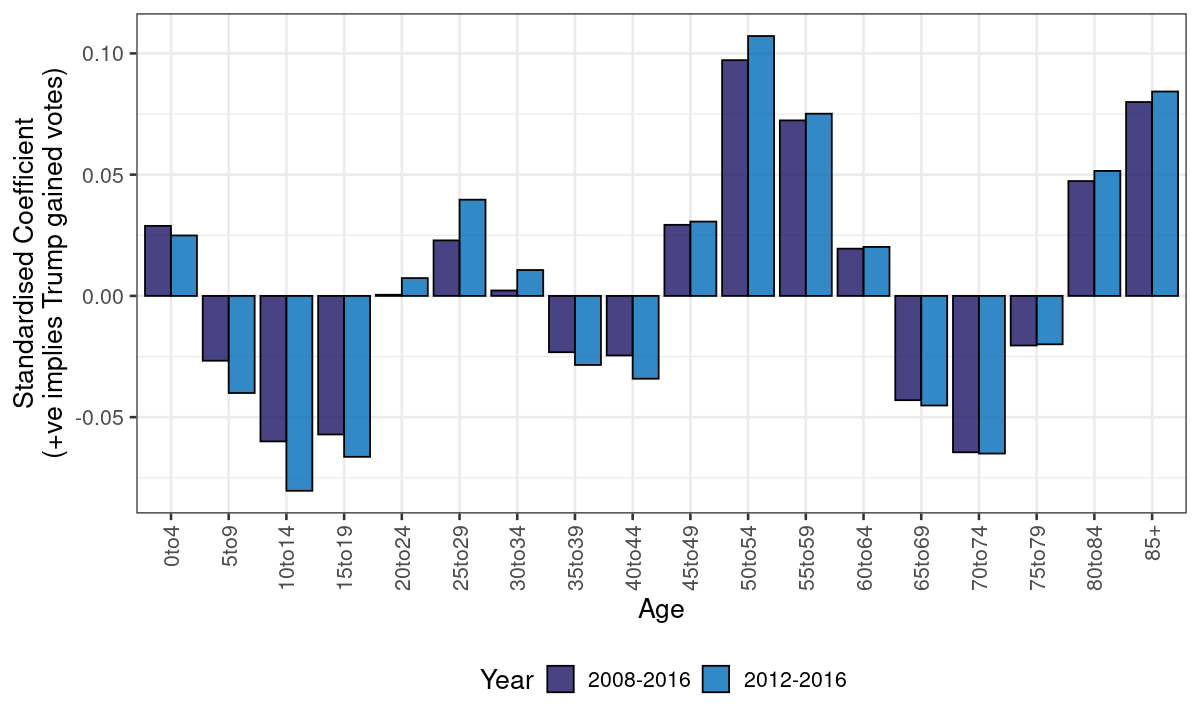

In [8]:
options(repr.plot.width = 10, repr.plot.height = 6)

age_idxs <- which(str_detect(colnames(predictors), r'{\d+(?:to\d+|\+)}'))
tibble(
  diff = c(pls_model$std.coefs[age_idxs,]),
  years = rep(c('2008-2016', '2012-2016'), each = 18),
  age = rep(colnames(predictors)[age_idxs], times = 2)
) %>%
  mutate(age = fct_reorder(age, as.integer(str_extract(age, r'{^\d+}')))) %>%
  ggplot(aes(age, diff, fill = years)) + 
    geom_col(position = 'dodge', alpha = 0.8, col = 'black') +
    labs(
      x = "Age",
      y = "Standardised Coefficient\n(+ve implies Trump gained votes)",
      fill = "Year"
    ) +
    scale_fill_manual(values = c('#1C1364', '#006CB6')) +
    theme(
      legend.position = 'bottom',
      axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1)
    )

This is an unusual finding, and we take two conclusions from this. Firstly, the generational divide in politics does exist. In terms of Trump-populism, there is no linear adage we can apply, such as "the older you get, the more conservative you become". Instead the trends are highly generational (think baby boomers, Generation Z, millennials, etc.). This cyclic nature of history is supported by [Peter Turchin's recent work](https://www.theguardian.com/technology/2019/nov/12/history-as-a-giant-data-set-how-analysing-the-past-could-help-save-the-future) suggesting that many historical and political trends can be modelled surprisingly well using periodic systems. Secondly, a key base of Trump’s was the older working population; people in full-time work, but pre-retirement seemed to be particularly enamored with Trump's message compared with previous Republicans'.

### Industry

With the knowledge that Trump swung five “rust belt” states his way, and that these are known for their waning manufacturing industries, it was critical that we included industry breakdowns in our model formulation. From this, we found a strong positive swing to Trump from production workers, corroborating the theory that this is how he swung these particular states. Clearly, this played a huge part of his campaign, aiming rhetoric at returning jobs to America and backing American manufacturing.

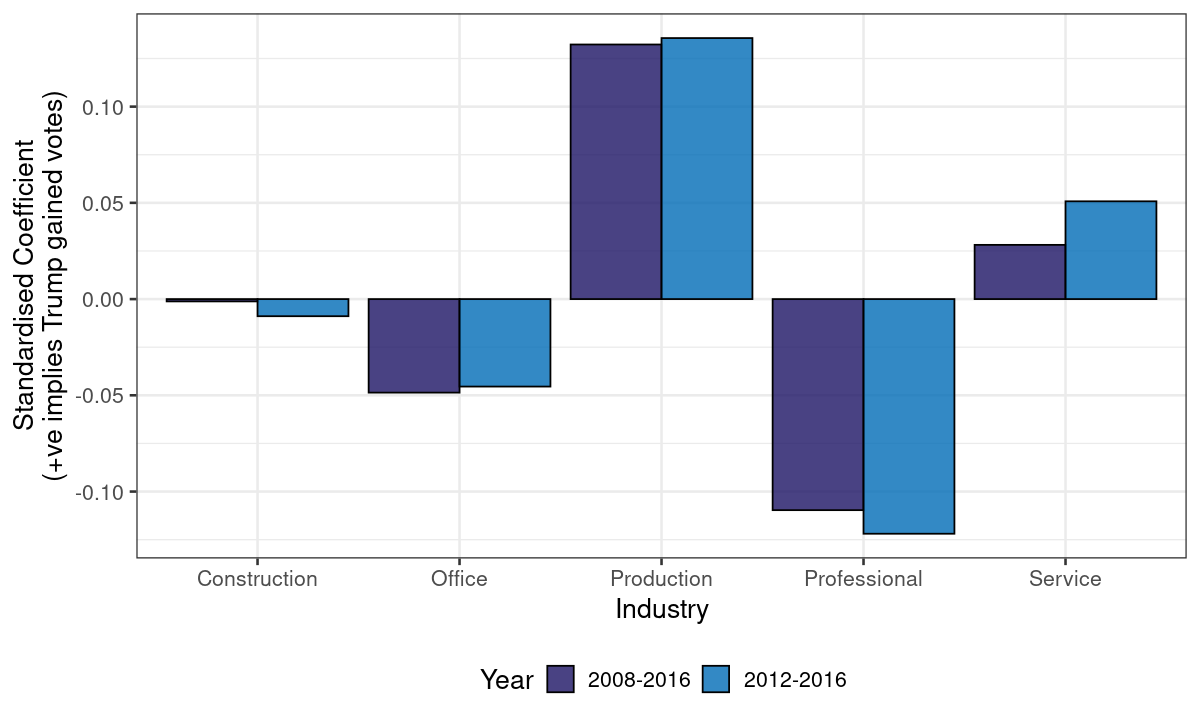

In [9]:
options(repr.plot.width = 10, repr.plot.height = 6)

industry_idxs <- which(colnames(predictors) %in% c("Construction", "Office", "Production", "Professional", "Service"))
tibble(
  diff = c(pls_model$std.coefs[industry_idxs,]),
  years = rep(c('2008-2016', '2012-2016'), each = 5),
  industry = rep(colnames(predictors)[industry_idxs], times = 2)
) %>%
  ggplot(aes(industry, diff, fill = years)) + 
    geom_col(position = 'dodge', alpha = 0.8, col = 'black') +
    labs(
      x = "Industry",
      y = "Standardised Coefficient\n(+ve implies Trump gained votes)",
      fill = "Year"
    ) +
    scale_fill_manual(values = c('#1C1364', '#006CB6')) +
    theme(legend.position = 'bottom')

This massive shift in voter base was essential for Trump’s win, as it allowed him to unexpectedly take the midwest, with it's large proportion of production workers.

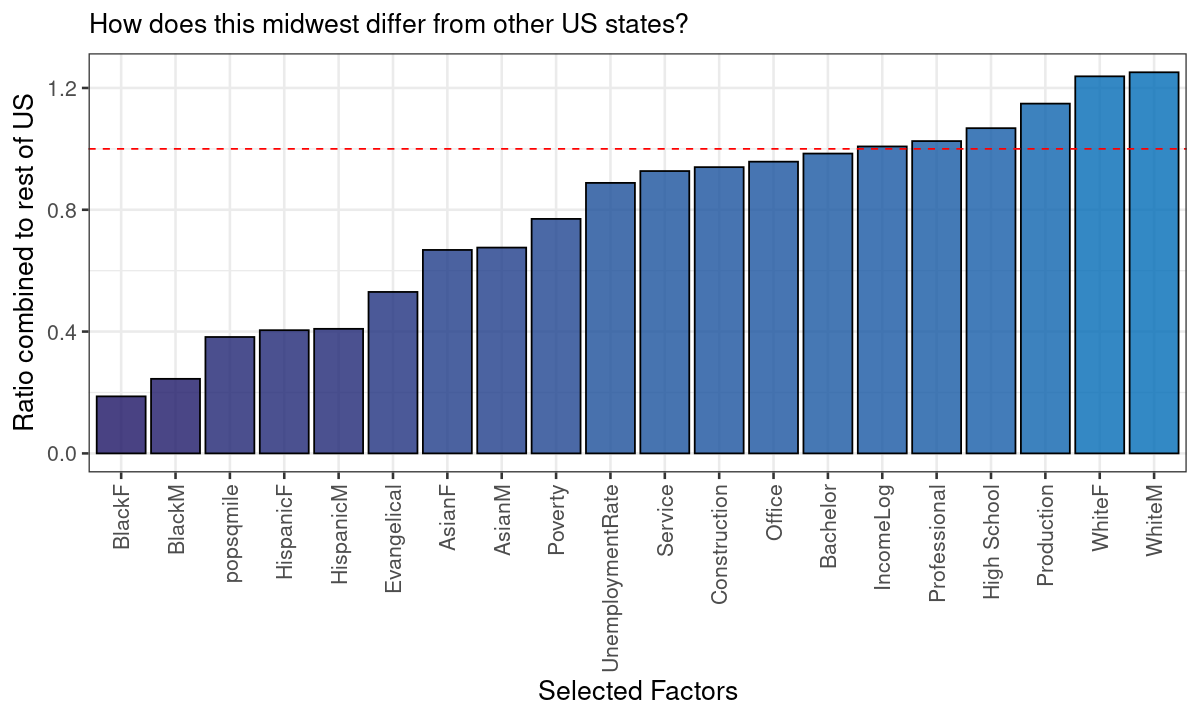

In [10]:
options(repr.plot.width = 10, repr.plot.height = 6)

predictors %>%
  mutate(focus = identifers$state %in% c(
      'Illinois', 'Indiana', 'Iowa', 'Kansas',
      'Michigan', 'Missouri', 'Minnesota', 'Nebraska',
      'North Dakota', 'Ohio', 'South Dakota', 'Wisconsin'
  )) %>%
  gather(-focus, key = 'variable', value = 'value') %>%
  group_by(variable, focus) %>%
  summarise(value = mean(value), .groups = 'drop') %>%
  filter(!str_detect(variable, '\\d')) %>%
  filter(!variable %in% c(
      'Black Prot', 'Catholic', 'Mainline', 'Evanelical'
  )) %>%
  spread(focus, value) %>%
  mutate(ratio = `TRUE` / `FALSE`, variable = fct_reorder(variable, ratio)) %>%
  ggplot(aes(variable, ratio, fill = ratio)) + 
    geom_col(position = 'dodge', alpha = 0.8, col = 'black', show.legend = FALSE) +
    labs(
      x = "Selected Factors",
      y = "Ratio combined to rest of US",
      subtitle = "How does this midwest differ from other US states?"
    ) +
    geom_hline(yintercept = 1, col = 'red', linetype = 'dashed') +
    scale_fill_gradient(high = '#006CB6', low = '#1C1364') + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1))

### Race

The graph above also hints that race played a large role in Trump's victory. Our model confirms this, highlighting in particular that white people swung heavily towards Trump, whereas black and hispanic people swung away. This is particularly relevant to the midwest, since it is one of the whiter areas of the US, meaning Trump’s success here, and therefore in the election at large, can be partially attributed to his success in winning over white people.

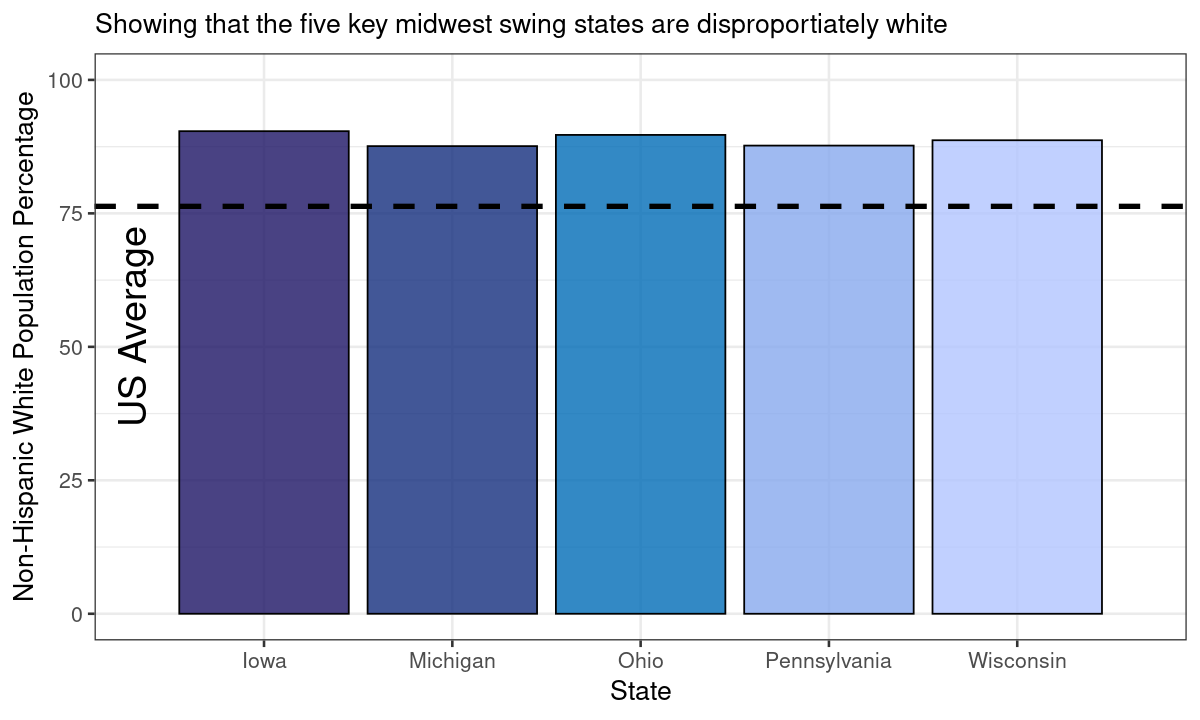

In [11]:
options(repr.plot.width = 10, repr.plot.height = 6)

combi %>%
    group_by(state) %>%
    summarise(non_hisp = round(100 * mean(WhiteF + WhiteM, na.rm = TRUE), 1),
              .groups = 'drop') %>%
    filter(state %in% c("Iowa", "Wisconsin", "Ohio", "Pennsylvania", "Michigan")) %>%
    ggplot(aes(state, non_hisp, fill = state)) + 
        geom_col(alpha = 0.8, col = 'black', show.legend = FALSE) +
        geom_hline(yintercept = 100 * mean(combi$WhiteF + combi$WhiteM, na.rm = TRUE),
                   linetype = 'dashed', size = 1.5) +
        annotate(geom = "text", x = 0.3, y = 100 * mean(combi$WhiteF + combi$WhiteM, na.rm = TRUE),
                 label = "US Average", size = 8, angle = 90, hjust = 1.1) +
        labs(
          x = "State",
          y = "Non-Hispanic White Population Percentage",
          subtitle = "Showing that the five key midwest swing states are disproportiately white"
        ) +
        scale_fill_manual(values = c('#1C1364', '#132E7D', '#006CB6', '#87a9ed', '#B2C4FF')) +
        scale_y_continuous(limits = c(0, 100)) +
        scale_x_discrete(expand = c(0, 0.9)) +
        theme(legend.position = 'bottom')

In fact, our data had a higher fidelity than race alone, including the intersection of common races and sexes. This allows us to also note, perhaps unsurprisingly, that Trump gained more male votes than female, regardless of race.

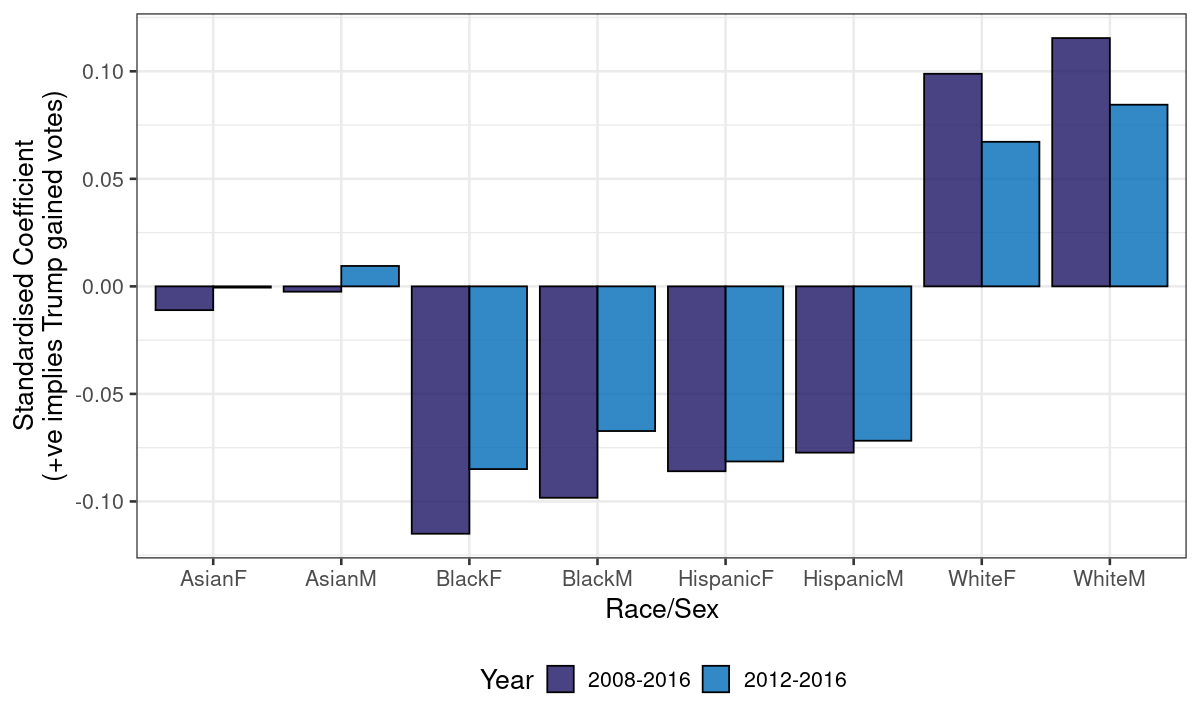

In [12]:
options(repr.plot.width = 10, repr.plot.height = 6)

race_sex_idxs <- which(str_detect(colnames(predictors), r'{(?:M|F)$}'))
tibble(
  diff = c(pls_model$std.coefs[race_sex_idxs,]),
  years = rep(c('2008-2016', '2012-2016'), each = length(race_sex_idxs)),
  race_sex = rep(colnames(predictors)[race_sex_idxs], times = 2)
) %>%
  ggplot(aes(race_sex, diff, fill = years)) + 
    geom_col(position = 'dodge', alpha = 0.8, col = 'black') +
    labs(
      x = "Race/Sex",
      y = "Standardised Coefficient\n(+ve implies Trump gained votes)",
      fill = "Year"
    ) +
    scale_fill_manual(values = c('#1C1364', '#006CB6')) +
    theme(legend.position = 'bottom')

### Religion

Effectively coding religious demography proved challenging, as there are a huge range of denominations, many having relatively few adherents. Our goal was to balance out religous fidelity with introducing too many variables as to add noise to the model. In the end, we separated Evangelical groups into their own category, as there was (and still is) [a lot of speculation](https://play.acast.com/s/intelligencesquared/whydoevangelicalsworshipatthealtarofdonaldtrump-withsarahposnerandbrianklaas) that they played a crucial role in his victory. Despite this, the data strongly suggests that this variable is largely unimportant, as Trump seemed to lose Evangelical votes, but still performed well enough to win in Republican heartlands. The swing against Trump in the “bible belt” was minor, and insufficient to change the election outcome. This a fascinating example of how data science lets us see past our preconceptions and biases, to understand problems with greater clarity.

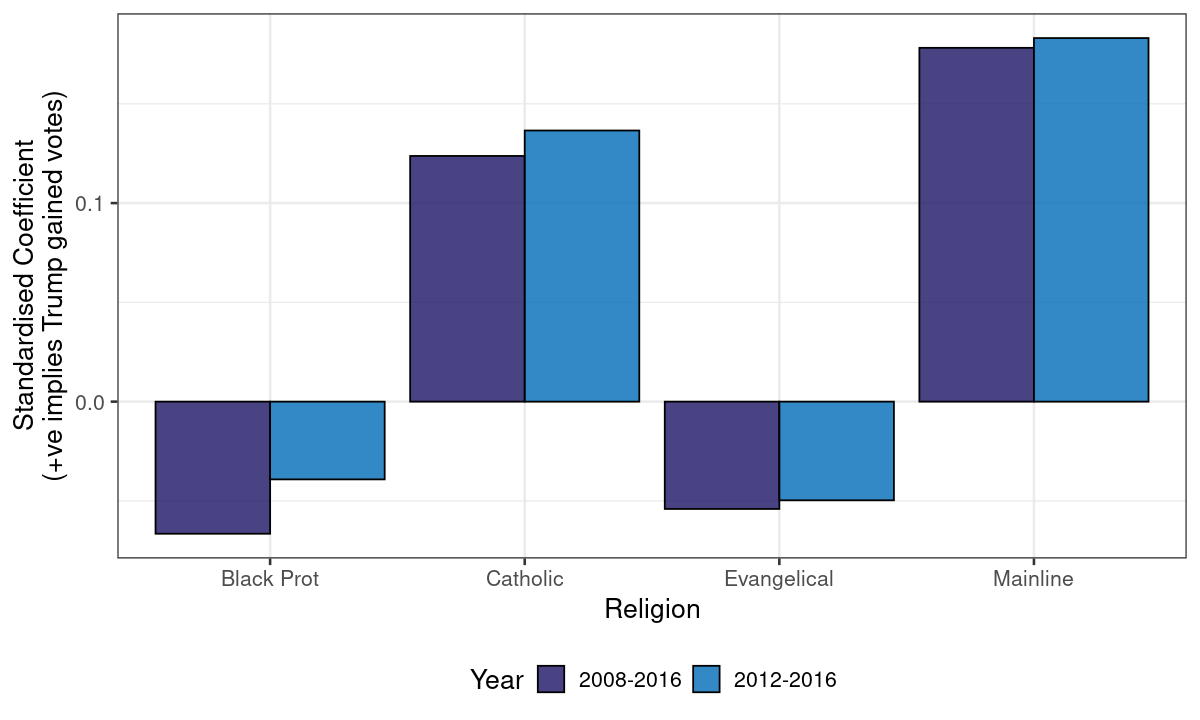

In [13]:
options(repr.plot.width = 10, repr.plot.height = 6)

religion_idxs <- which(colnames(predictors) %in% c("Mainline", "Evangelical", "Catholic", "Black Prot"))
tibble(
  diff = c(pls_model$std.coefs[religion_idxs,]),
  years = rep(c('2008-2016', '2012-2016'), each = length(religion_idxs)),
  religion = rep(colnames(predictors)[religion_idxs], times = 2)
) %>%
  ggplot(aes(religion, diff, fill = years)) + 
    geom_col(position = 'dodge', alpha = 0.8, col = 'black') +
    labs(
      x = "Religion",
      y = "Standardised Coefficient\n(+ve implies Trump gained votes)",
      fill = "Year"
    ) +
    scale_fill_manual(values = c('#1C1364', '#006CB6')) +
    theme(legend.position = 'bottom')

For reference, the religious distributions for both the midwest and remaining US are shown below.

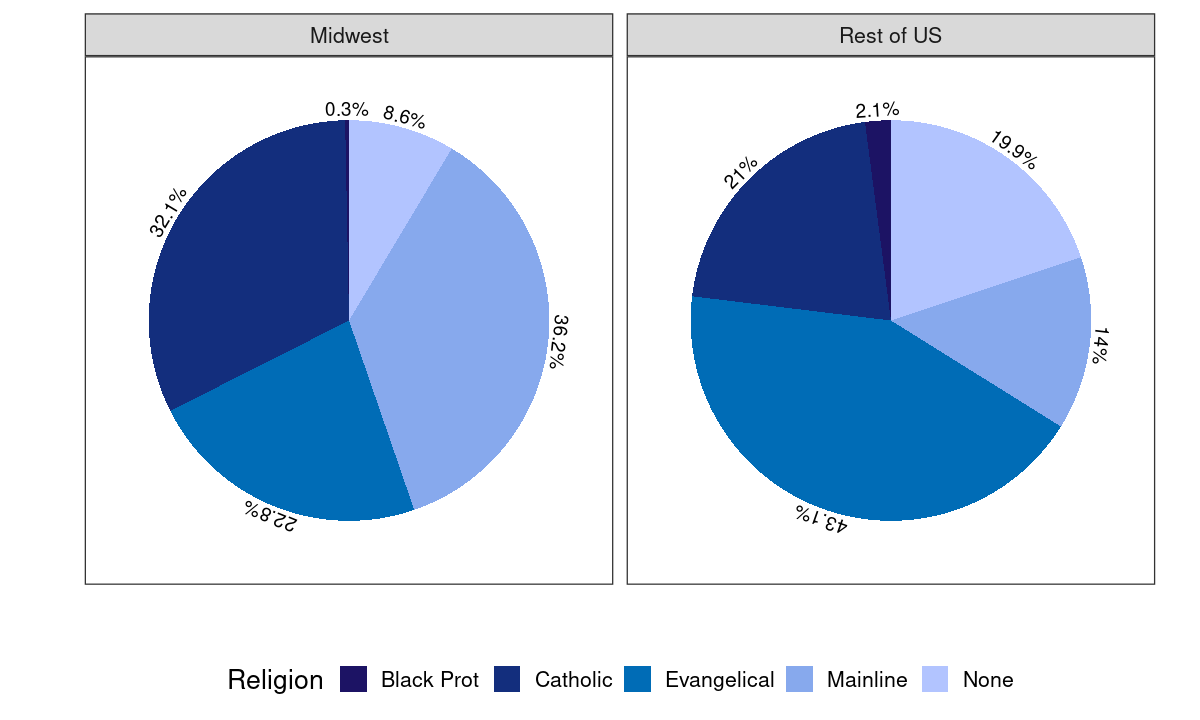

In [14]:
options(repr.plot.width = 10, repr.plot.height = 6)

combi %>%
    select(state, Mainline, Evangelical, Catholic, `Black Prot`) %>%
    mutate(None = 1000 - Mainline - Evangelical - Catholic - `Black Prot`) %>%
    mutate(is_ohio = ifelse(state %in% c(
      'Illinois', 'Indiana', 'Iowa', 'Kansas',
      'Michigan', 'Missouri', 'Minnesota', 'Nebraska',
      'North Dakota', 'Ohio', 'South Dakota', 'Wisconsin'
  ), "Midwest", "Rest of US")) %>%
    select(-state) %>%
    group_by(is_ohio) %>%
    summarise_all(mean) %>%
    gather(key = "religion", value = "prop", -is_ohio) %>%
    group_by(is_ohio) %>%
    arrange(desc(religion)) %>%
    mutate(prop = prop / sum(prop),
           cumprop = cumsum(prop) / sum(prop),
           cumprop = (cumprop + replace_na(lag(cumprop), 0)) / 2) %>%
    ggplot(aes(x = 0, y = prop, fill = religion)) +
        geom_col(position = "fill") +
        geom_text(aes(x = 0.5, y = cumprop,
                      label = str_c(round(prop * 100, 1), "%"),
                      angle = 360 - cumprop * 360),
                  col = "black", size = 4) +
        coord_polar(theta = 'y') +
        labs(x = "", y = "", fill = "Religion") +
        scale_fill_manual(values = c('#1C1364', '#132E7D', '#006CB6', '#87a9ed', '#B2C4FF')) +
        facet_wrap(~is_ohio) +
        theme(
            legend.position = 'bottom',
            axis.text = element_blank(),
            axis.ticks = element_blank(),
            panel.grid = element_blank()
        )

### Education & Income

The crucial findings in this area show us both how different Trump was as a candidate compared to previous Republicans, and also how largely unimportant certain swings were. In terms of education, Trump was incredibly unpopular, facing a large negative swing from bachelor's degree holders. However, this did little to impact his success. One explanation for this is that educational attainment is concentrated in areas where Democrats are already successful, so in the “winner takes all” system of the US, a further loss was largely irrelevant.

Conversely, unemployment and poverty correlated positively with Trump voters, further backing our argument of him taking traditional Democrat voter groups.

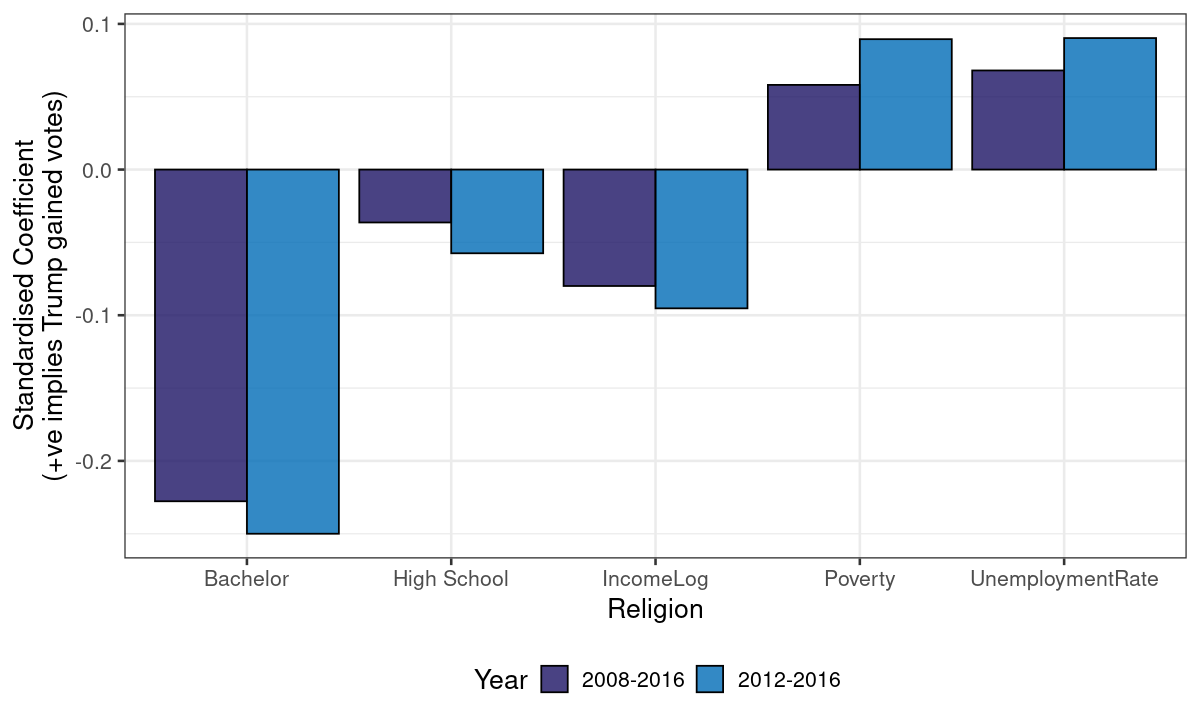

In [15]:
options(repr.plot.width = 10, repr.plot.height = 6)

religion_idxs <- which(colnames(predictors) %in% c("High School", "Bachelor", "UnemploymentRate", "IncomeLog", "Poverty"))
tibble(
  diff = c(pls_model$std.coefs[religion_idxs,]),
  years = rep(c('2008-2016', '2012-2016'), each = length(religion_idxs)),
  religion = rep(colnames(predictors)[religion_idxs], times = 2)
) %>%
  ggplot(aes(religion, diff, fill = years)) + 
    geom_col(position = 'dodge', alpha = 0.8, col = 'black') +
    labs(
      x = "Religion",
      y = "Standardised Coefficient\n(+ve implies Trump gained votes)",
      fill = "Year"
    ) +
    scale_fill_manual(values = c('#1C1364', '#006CB6')) +
    theme(legend.position = 'bottom')

The impact of the change in Trump's appeal towards bachelor's degree holders is easily seen when we plot a heatmap of bachelor degree attainment; a dark patch is centred lower midwest where key swing states are located.

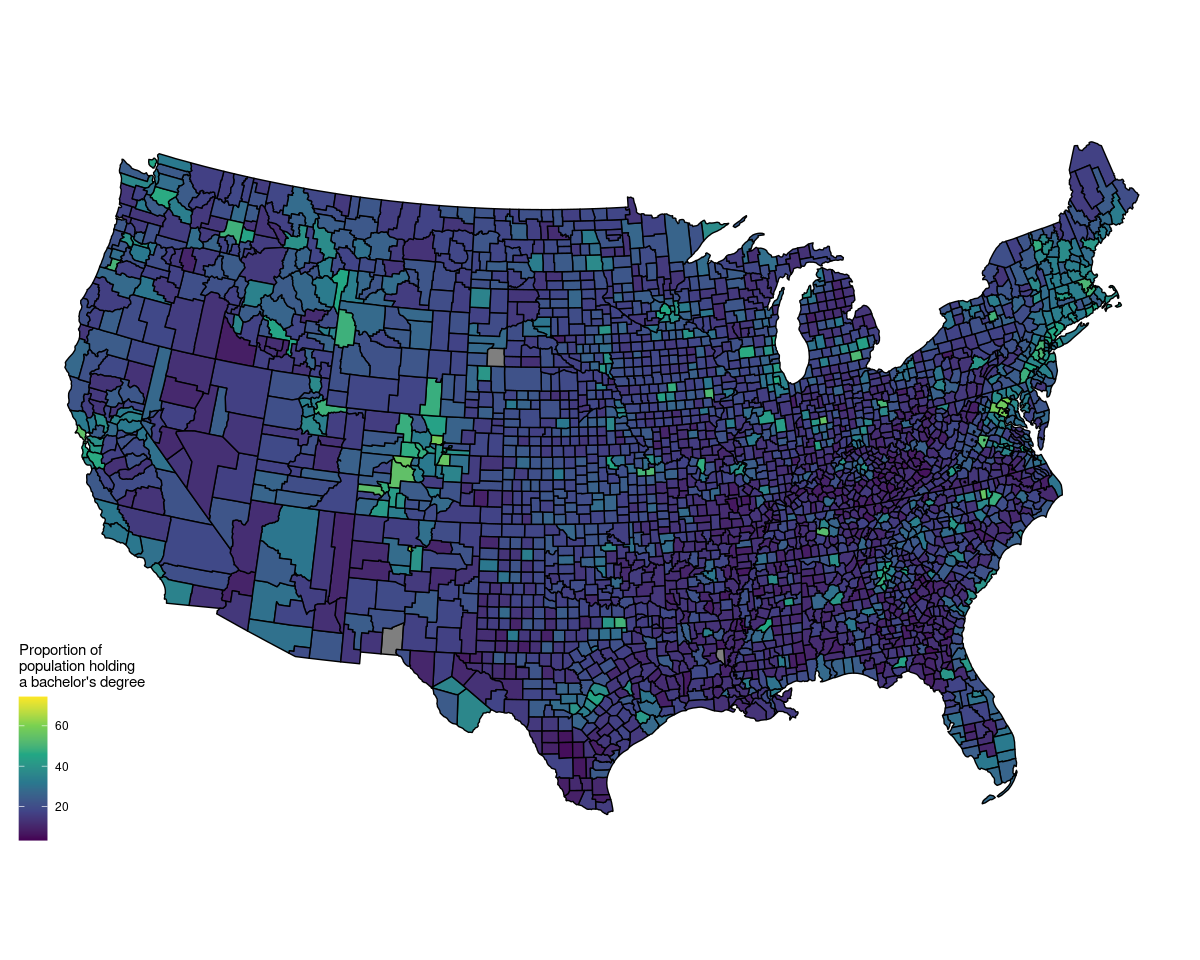

In [33]:
options(repr.plot.width = 10, repr.plot.height = 8)

oldw <- getOption("warn")
options(warn=-1)
col_var <- 'Bachelor'
combi %>%
  select_('fips', 'Bachelor') %>%
  usmap::plot_usmap(regions = 'state', data = ., exclude = c("Alaska", "Hawaii"),
                    values = 'Bachelor') +
  labs(fill = "Proportion of\npopulation holding\na bachelor's degree") +
  scale_fill_viridis_c()
options(warn=oldw)

### Outliers

Overall, we believe that our model is a strong success. Not only does it provide evidence for several previously speculative theories, it also casts doubt on some unproven beliefs. Our model captures a good proportion of the variability of the response with a desirable error distribution.

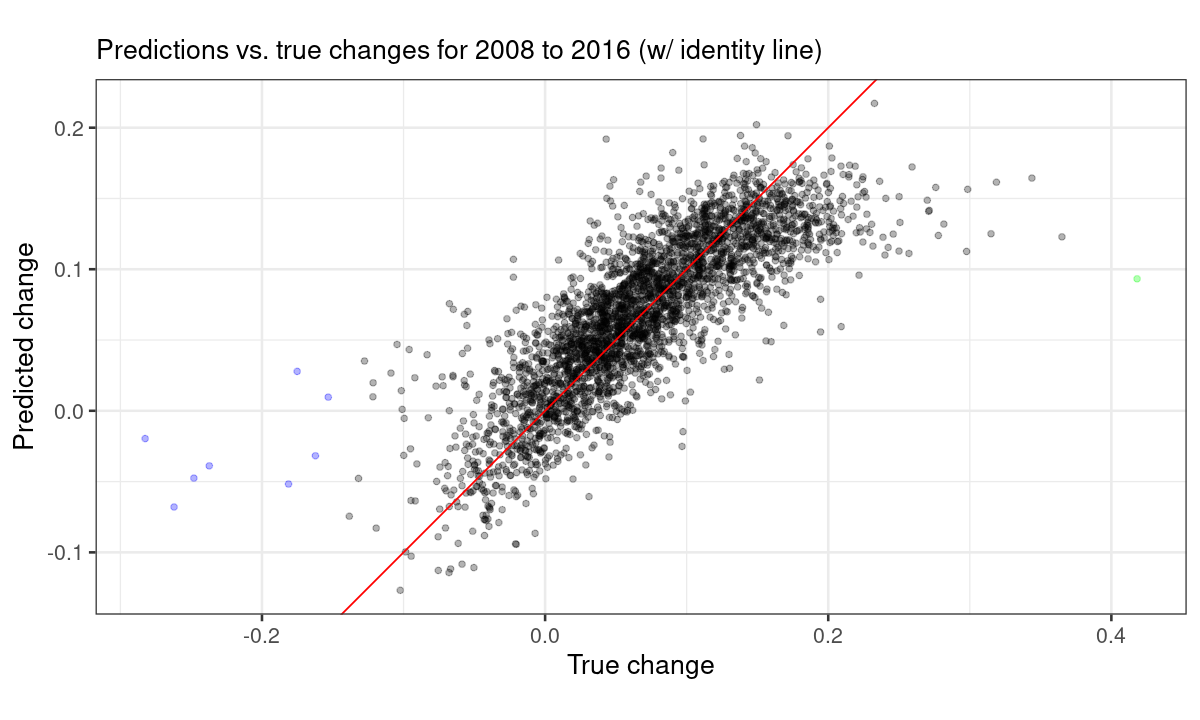

In [35]:
options(repr.plot.width = 10, repr.plot.height = 6)

combi %>%
  select(truth = diff0816, county, state) %>%
  mutate(
    pred = pls_model$y.pred[, 1],
    marker = factor(case_when(
      state == "Indiana" & truth > 0.4 ~ 1,
      truth < -0.15 ~ 2,
      TRUE ~ 0
    ))
  ) %>%
  ggplot(aes(truth, pred, col = marker)) +
    geom_point(alpha = 0.3, show.legend = FALSE) +
    geom_abline(col = 'red') +
    scale_color_manual(values = c('black', 'green', 'blue')) +
    labs(
        x = "True change",
        y = "Predicted change",
        subtitle = "Predictions vs. true changes for 2008 to 2016 (w/ identity line)"
    ) +
    coord_fixed()

As with all models, outliers exist, but these can be easily explained. On one end (marked blue), we overpredicted the swing from several counties in Utah and Idaho. That is, based on the trends we saw elsewhere, our model suggested he should have performed better than he did. This deviation from our predictions can be explained in one word—Mormons. Many counties in this region of the US were settled by the Church of Latter Day Saints, leading to a third Mormon candidate, Evan MacMullin, claiming a sizeable share of votes (20% in Utah, 6% in Idaho) largely from Trump, leading to this minor discrepancy in our model.

On the other end of the spectrum, we have areas such as Laporte County, Indiana (marked green) which we underpredicted. In other words, Trump did better in these areas than our model predicted. This is partially explained by Trump choosing Mike Pence to be his running mate. VP candidates are often hand-picked to help “deliver” a region. In this case, Pence was a longterm governor from a rust belt state. The model does not have a way to account for the running mate effect (though this could be introduced with manual feature engineering), hence underpredicted the swing Trump will have obtained from choosing Indiana-favourite Pence as running mate. 

## Conclusion

With that, we conclude our whirlwind tour of Trump's 2016 presidential victory. Our model has cast light on Trump’s effect and dependence on a unique coalition of states in order to pull off his unexpected win. Upon analysing trends in historical patterns, we find that traditional left/right distributions (such as income and religion) were largely unimportant in this election, particularly compared to education levels and industry distributions. 

Our work also highlights the groups that Trump must retain in order to win again in 2020. Much is made of his performance with evangelical groups—traditionally bastions of the Republican party—but our data-driven approach shows that this is largely a side factor, contrary to popular speculation. To win again, Trump doesn’t need more votes in evangelical areas—the "bible belt” as it is usually known—but instead, he must retain workers in the production industry, and the older working generation. This enabled him to win the midwest states that were sufficient to edge him into the White House and could quite possibly keep him there.

This project showcases data science at its best, bringing together statistics, computer science, and domain expertise to solve an old problem in a new way. With this collaboration of disiplines, such conclusions would not be possible: political speculation and theory would lack supportive evidence that can only be derived through advanced statistical modelling; on the other hand, without the ability to tie model results to reality using domain knowledge and insight, the practicality and real-life validity of a statistical model can rarely be relied upon. This project was only facilitated by Warwick Data Science Society's community of students and the infrastructure they provide for blogging. We hope that this post inspires fellow students to consider the insight that data science can bring to their field and to engage with WDSS to produce similar works. Thank you for reading.

## Appendix

In [18]:
cat("Table of Standardized Coefficients\n")
cat("==================================\n\n")
print(round(pls_model$std.coefs, 3))

Table of Standardized Coefficients

                 diff0816 diff1216
0to4                0.029    0.025
10to14             -0.060   -0.080
15to19             -0.057   -0.066
20to24              0.000    0.007
25to29              0.023    0.040
30to34              0.002    0.011
35to39             -0.023   -0.028
40to44             -0.025   -0.034
45to49              0.029    0.031
5to9               -0.027   -0.040
50to54              0.097    0.107
55to59              0.072    0.075
60to64              0.019    0.020
65to69             -0.043   -0.045
70to74             -0.064   -0.065
75to79             -0.020   -0.020
80to84              0.047    0.052
85+                 0.080    0.084
AsianF             -0.011   -0.001
AsianM             -0.002    0.009
BlackF             -0.115   -0.085
BlackM             -0.098   -0.067
HispanicF          -0.086   -0.081
HispanicM          -0.077   -0.072
WhiteF              0.099    0.067
WhiteM              0.115    0.084
UnemploymentRate   

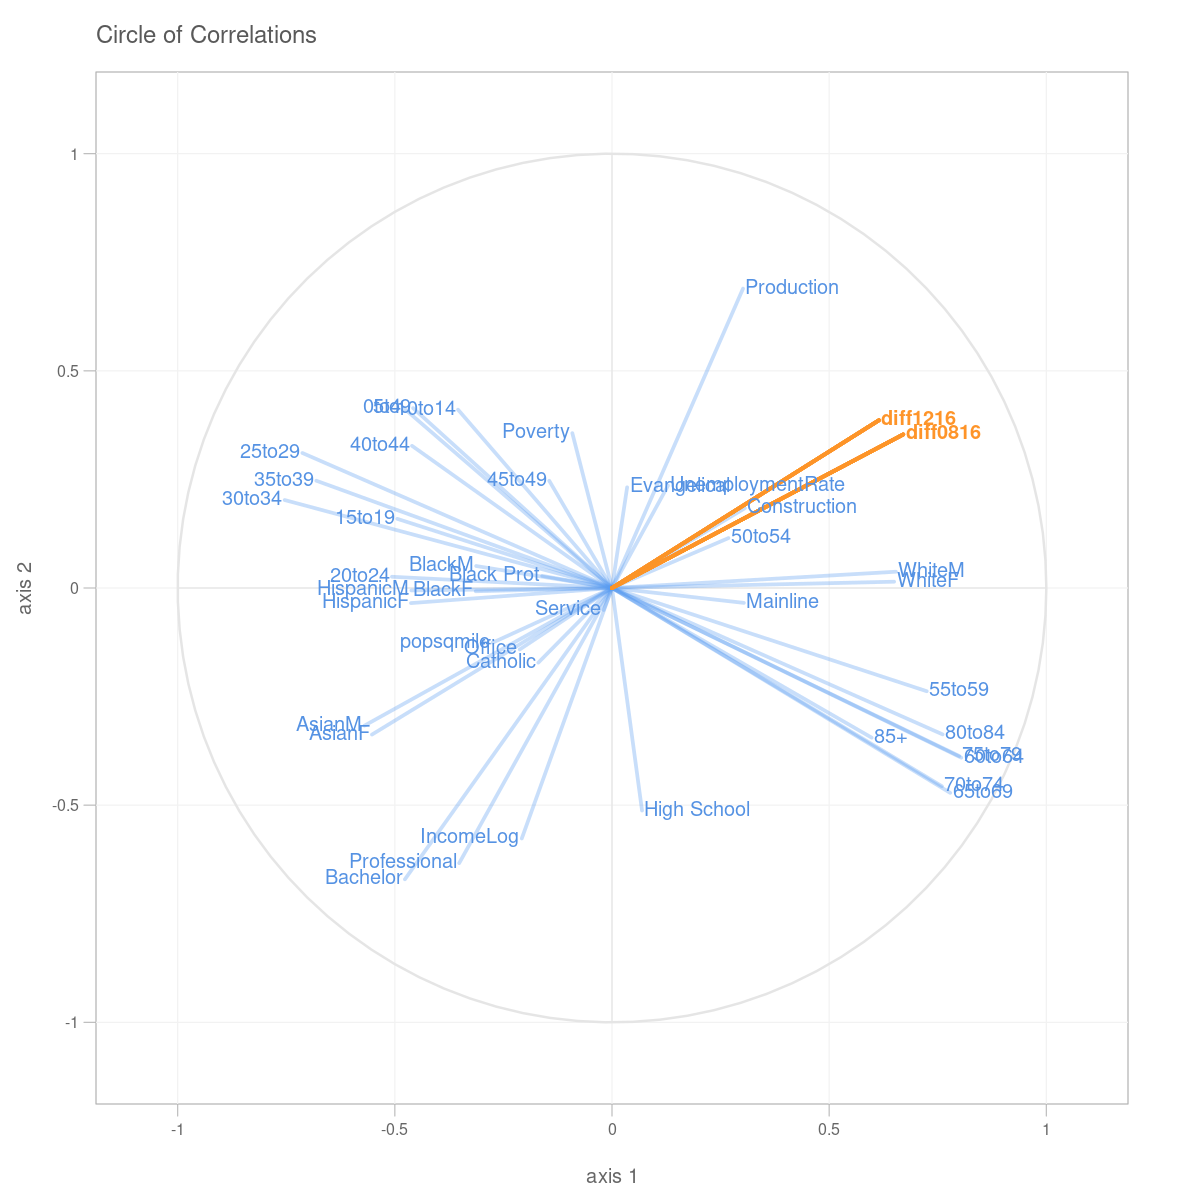

In [19]:
options(repr.plot.width = 10, repr.plot.height = 10)
plot(pls_model)